## Match NCES School Data to School Building Data

The National Center for Education Statistics provides annual data on schools (public, private, postsecondary) as well as key characteristics (staff and student counts).

This data can be matched to the nearest buildings identified as school buildings.


Based on help from:

https://osmnx.readthedocs.io/en/stable/osmnx.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.query.html

Goal is to accurately assign business information to buildings.


## Description of Program
- program:    IN-CORE_2bv1_MatchNCESSchoolBuilding
- task:       Match NCES point data to nearest building location
- Version:    2021-06-17
-             2021-06-18 - using pyincore_addons.geoutil_20210618.py
- project:    Interdependent Networked Community Resilience Modeling Environment (IN-CORE) Subtask 5.2 - Social Institutions
- funding:	  NIST Financial Assistance Award Numbers: 70NANB15H044 and 70NANB20H008 
- author:     Nathanael Rosenheim

- Suggested Citation:
Rosenheim, N. (2021) “Obtain, Clean, and Explore Labor Market Allocation Methods". 
Archived on Github and ICPSR.

In [1]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np  # group by aggregation
import folium as fm # folium has more dynamic maps - but requires internet connection

In [2]:
# Display versions being used - important information for replication
import sys
print("Python Version     ", sys.version)
print("geopandas version: ", gpd.__version__)
print("pandas version:    ", pd.__version__)
print("numpy version:     ", np.__version__)
print("folium version:    ", fm.__version__)

Python Version      3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 15:37:01) [MSC v.1916 64 bit (AMD64)]
geopandas version:  0.9.0
pandas version:     1.3.1
numpy version:      1.21.1
folium version:     unknown


In [3]:
import os # For saving output to path
# Store Program Name for output files to have the same name
programname = "IN-CORE_2bv1_MatchNCESSchoolBuilding_2021-08-18"
# Make directory to save output
if not os.path.exists(programname):
    os.mkdir(programname)

# Setup access to IN-CORE
https://incore.ncsa.illinois.edu/

In [4]:
from pyincore import IncoreClient, Dataset, FragilityService, MappingSet, DataService
from pyincore_viz.geoutil import GeoUtil as viz

In [5]:
#client = IncoreClient()
# IN-CORE chaches files on the local machine, it might be necessary to clear the memory
#client.clear_cache()

In [6]:
# create data_service object for loading files
#data_service = DataService(client)

### IN-CORE addons
This program uses coded that is being developed as potential add ons to pyincore. These functions are in a folder called pyincore_addons - this folder is located in the same directory as this notebook.
The add on functions are organized to mirror the folder sturcture of https://github.com/IN-CORE/pyincore

Each add on function attempts to follow the structure of existing pyincore functions and includes some help information.

In [7]:
# open, read, and execute python program with reusable commands
import pyincore_addons.geoutil_20210618 as add2incore

# since the geoutil is under construction it might need to be reloaded
from importlib import reload 
add2incore = reload(add2incore)

# Print list of add on functions
from inspect import getmembers, isfunction
print(getmembers(add2incore,isfunction))

[('df2gdf_WKTgeometry', <function df2gdf_WKTgeometry at 0x000002AF606D9CA8>), ('nearest_pt_search', <function nearest_pt_search at 0x000002AF5B20CCA8>)]


## Read in Building Data


In [8]:
sourceprogram = "IN-CORE_1gv1_Lumberton_SchoolBuildingData_2021-06-17"
filename = sourceprogram+"/"+sourceprogram+"_schoolbuildings.csv"
building_df = pd.read_csv(filename)

# Convert dataframe to gdf
building_gdf = add2incore.df2gdf_WKTgeometry(df = building_df, projection = "epsg:4326",reproject="epsg:26917")
building_gdf.head(2)

,Unnamed: 0,guid,strctid,ffe_elev,archetype,parid,struct_typ,no_stories,a_stories,b_stories,...,str_typ2,occ_typ2,appr_bldg,appr_land,appr_tot,year_built,lhsm_elev,g_elev,age_group,geometry
0,2270,66b1392e-c7b0-4bd8-a092-a7ff0ea6c15a,ST66b1392e-c7b0-4bd8-a092-a7ff0ea6c15a,43.88056,10,3715519218,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1978.0,NaN,NaN,2.0,POINT (672189.465 3829164.868)
1,2271,31d34dad-4211-40d9-b4e3-38677b5ee72f,ST31d34dad-4211-40d9-b4e3-38677b5ee72f,43.86102,10,3715519217,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1978.0,NaN,NaN,2.0,POINT (672181.958 3829181.790)


In [9]:
help(viz.plot_gdf_map)

Help on function plot_gdf_map in module pyincore_viz.geoutil:

plot_gdf_map(gdf, column, category=False, basemap=True, source={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': '(C) OpenStreetMap contributors', 'name': 'OpenStreetMap.Mapnik'})
    Plot Geopandas DataFrame.
    
    Args:
        gdf (obj): Geopandas DataFrame object.
        column (str): A column name to be plot.
        category (bool): Turn on/off category option.
        basemap (bool): Turn on/off base map (e.g. openstreetmap).
        source(obj): source of the Map to be used. examples, ctx.providers.OpenStreetMap.Mapnik (default),
            ctx.providers.Stamen.Terrain, ctx.providers.CartoDB.Positron etc.



Map of school buildings 10 = One Story [84], 11 = Two Story [4]


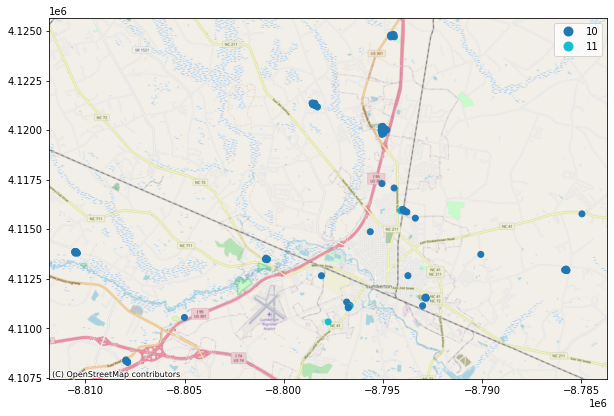

In [10]:
map = viz.plot_gdf_map(building_gdf,column='archetype', category=True)
print("Map of school buildings 10 = One Story [84], 11 = Two Story [4]")
map

In [11]:
building_gdf['guid'].describe()

count                                       88
unique                                      88
top       66b1392e-c7b0-4bd8-a092-a7ff0ea6c15a
freq                                         1
Name: guid, dtype: object

## Read in NCES School Data

In [12]:
sourcefolder = '../SourceData/nces.ed.gov/WorkNPR/'
sourceprogram = "NCES_2bv1_AddTeacherCount_2021-06-15"
filename = sourcefolder+"/"+sourceprogram+"/"+sourceprogram+".csv"
school_df = pd.read_csv(filename)

# Convert dataframe to gdf
school_gdf = add2incore.df2gdf_WKTgeometry(df = school_df, projection = "epsg:4326",reproject="epsg:26917")
school_gdf.head()

,Unnamed: 0,ncesid,HRTOTLT,ppin,p410,FTE,Unnamed: 0.1,name,addr,city,stabbr,zip,cnty15,geometry,level,schtype,lat,lon,schyr,numstaff
0,0,370004002349,NaN,NaN,NaN,7.99,0,CIS Academy,818 West 3rd Street,Pembroke,NC,28372,37155,POINT (664581.949 3839584.931),99,1,34.685038,-79.203357,2015-2016,7.99
1,1,370034603302,NaN,NaN,NaN,15.00,1,Southeastern Academy,12251 NC HWY 41 North,Lumberton,NC,28358,37155,POINT (694854.567 3836475.290),99,1,34.651697,-78.873789,2015-2016,15.00
2,2,370225003249,NaN,NaN,NaN,36.25,2,Sandy Grove Middle,300 Chason Road,Lumber Bridge,NC,28357,37155,POINT (676730.741 3863273.806),99,1,34.896510,-79.065819,2015-2016,36.25
3,3,370393001569,NaN,NaN,NaN,23.84,3,Deep Branch Elementary,4045 Deep Branch Road,Lumberton,NC,28360,37155,POINT (669947.382 3833617.725),99,1,34.630377,-79.146010,2015-2016,23.84
4,4,370393001570,NaN,NaN,NaN,22.98,4,Fairgrove Middle,1953 Fairgrove Sch Road,Fairmont,NC,28340,37155,POINT (667683.210 3818368.148),99,1,34.493298,-79.173707,2015-2016,22.98


NCES School Data for Robeson County]


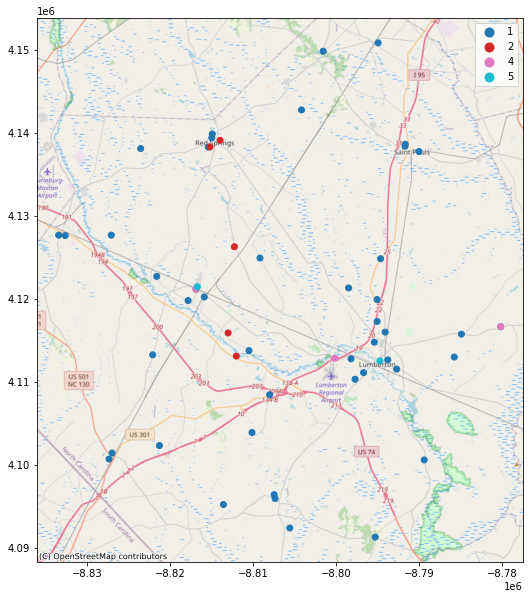

In [13]:
map = viz.plot_gdf_map(school_gdf,column='schtype', category=True)
print("NCES School Data for Robeson County]")
map

In [14]:
school_gdf['ncesid'].describe()

count               55
unique              55
top       370004002349
freq                 1
Name: ncesid, dtype: object

## Set up data for nearest neighbor search

Need to do this in the revese order as the businesses. For business there is one business location going to one building and one building could have multiple businesses...
In this case we want the one school id to go multiple nearby buildings.

## Run nearest neighbor algorithm

In [15]:
help(add2incore.nearest_pt_search)

Help on function nearest_pt_search in module pyincore_addons.geoutil_20210618:

nearest_pt_search(gdf_a: geopandas.geodataframe.GeoDataFrame, gdf_b: geopandas.geodataframe.GeoDataFrame, uniqueid_a: str, uniqueid_b: str, k=1, dist_cutoff=99999)
    Given two sets of points add unique id from locations a to locations b
    Inspired by: https://towardsdatascience.com/using-scikit-learns-binary-trees-to-efficiently-find-latitude-and-longitude-neighbors-909979bd929b
    
    This function is used to itdentify buildings associated with businesses, schools, hospitals.
    The locations of businesses might be geocoded by address and may not overlap
    the actual structure. This function helps resolve this issue.
    
    Tested Python Enviroment:
        Python Version      3.7.10
        geopandas version:  0.9.0
        pandas version:     1.2.4
        scipy version:     1.6.3
        numpy version:      1.20.2
    
    Args:
        gdf_a: Geodataframe with list of locations with unique i

In [16]:
buiding_nces_gdf = add2incore.nearest_pt_search(gdf_a = school_gdf,
                                               gdf_b = building_gdf,
                                               uniqueid_a = 'ncesid',
                                               uniqueid_b = 'guid',
                                               k = 6,
                                               dist_cutoff = 250)

In [17]:
buiding_nces_gdf.head()

,guid,geometry_x,LON_x,LAT_x,neighbor,distance,distoutlier,location a index,index,ncesid,geometry_y,LON_y,LAT_y
0,66b1392e-c7b0-4bd8-a092-a7ff0ea6c15a,POINT (672189.465 3829164.868),672189.465374,3.829165e+06,1,176.397646,False,20.0,20,370393002049,POINT (672082.102 3829304.830),672082.102055,3.829305e+06
1,31d34dad-4211-40d9-b4e3-38677b5ee72f,POINT (672181.958 3829181.790),672181.958294,3.829182e+06,1,158.461291,False,20.0,20,370393002049,POINT (672082.102 3829304.830),672082.102055,3.829305e+06
2,81370d16-d258-4dba-9405-f264534550c0,POINT (672172.253 3829203.772),672172.253080,3.829204e+06,1,135.424923,False,20.0,20,370393002049,POINT (672082.102 3829304.830),672082.102055,3.829305e+06
3,f1d92274-c480-4658-b5af-723436a08af9,POINT (672112.146 3829264.495),672112.145685,3.829264e+06,1,50.294193,False,20.0,20,370393002049,POINT (672082.102 3829304.830),672082.102055,3.829305e+06
4,942f44ec-e3a4-4e86-b5ee-79bb9a502d6e,POINT (672108.372 3829220.729),672108.371874,3.829221e+06,1,88.108336,False,20.0,20,370393002049,POINT (672082.102 3829304.830),672082.102055,3.829305e+06


In [18]:
buiding_nces_gdf[['neighbor','guid']].fillna('none').groupby(
    ['neighbor']).count()

,guid
neighbor,
1,78


In [19]:
buiding_nces_gdf.guid.describe()

count                                       78
unique                                      78
top       66b1392e-c7b0-4bd8-a092-a7ff0ea6c15a
freq                                         1
Name: guid, dtype: object

In [20]:
# Save Work at this point as CSV
savefile = sys.path[0]+"/"+programname+"/"+programname+".csv"
buiding_nces_gdf.to_csv(savefile)